# Kaggle Competition: Digit Recognizer with MNIST
https://www.kaggle.com/c/digit-recognizer

I've got some experience coding and using tensorflow at this point, but I've only done regression problems. I'd like to try my hand at my first computer vision/classification problem, and build my first convolutional neural network in tensorflow. 

### Setup
Let's begin the setup by importing the necesary libraries and datasets.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math as m
import os
import hashlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:.5f}'.format

filepath = os.path.join(os.getcwd(),"Data")

dataset = pd.read_csv(os.path.join(filepath,"train.csv"), index_col = None)
test = pd.read_csv(os.path.join(filepath,"test.csv"), index_col = None)

### Data exploration and cleanup

We'll take a look at the datasets and the columns and check if there are any missing labels in the dataset.

In [2]:
"Training Dataset Size (Rows, Columns): " + str(dataset.shape)
"Testing Dataset Size (Rows, Columns): " + str(test.shape)
dataset.head(n=3)
test.head(n=3)

"There are " + str(dataset.isnull().sum().sum()) + " missing labels in the training dataset."
"There are " + str(test.isnull().sum().sum()) + " missing labels in the testing dataset."

'Training Dataset Size (Rows, Columns): (42000, 785)'

'Testing Dataset Size (Rows, Columns): (28000, 784)'

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


'There are 0 missing labels in the training dataset.'

'There are 0 missing labels in the testing dataset.'

There are no missing labels in both the training dataset and the testing dataset.

Let's examine the pixel columns. 

According to https://www.kaggle.com/c/digit-recognizer/data , the images are 28 x 28 pixel (784 pixels in total) grayscale images of handwritten digits, "0" through "9". The first column in the training set is the actual handwritten digit, whereas the testing dataset lacks the actual digit label. That's for us to guess! 

The first 28 pixel columns (columns 000 to 027) are of the darkness levels (0 being white, and 255 being completely black) of the top most row of 28 pixels. Columns 028 to 055 are the second row from the top's darkness levels, and so on. 


### Checking for class imbalance

One thing to worry about that is unique to classification problems is class imbalance, where one class (or in this case, digit) is under or overrepresented in the dataset. If we have 99% "3's" and the remaining 1% are the remaining digits, a "dumb" classifier that guesses "3" for every image given, would have 99% correct classifications right off the bat. We'll check for any class imbalances in the training dataset.

In [3]:
digit_counts = dataset["label"].value_counts().to_frame()
digit_counts.columns = ["Occurrences"]
digit_counts.columns.name = "Digit"
digit_counts["Frequency(%)"] = (digit_counts["Occurrences"]/digit_counts["Occurrences"].sum())*100
digit_counts["Relative Frequency"] = digit_counts["Occurrences"]/digit_counts["Occurrences"].min()
digit_counts

Digit,Occurrences,Frequency(%),Relative Frequency
1,4684,11.15238,1.23426
7,4401,10.47857,1.15968
3,4351,10.35952,1.14651
9,4188,9.97143,1.10356
2,4177,9.94524,1.10066
6,4137,9.85000,1.09012
0,4132,9.83810,1.08880
4,4072,9.69524,1.07299
8,4063,9.67381,1.07062
5,3795,9.03571,1.00000


While not a perfect 1/10 split amongst all the digits, this imbalance is minor, with the most common class, "1", appearing only 1.234 times as much as the least frequent class, "5".

### Prepping the Data

Let's seperate our training dataset into a training and validation set. The training set is used to fit the models, and the validation set is used to adjust the hyperparamters (variables that are preset and not adjusted during the training process) to achieve the best fit. 

We'll split the dataset based on the hash of the dataframe's index. 

In [4]:
def test_split(id, seed, test_proportion):
    if type(test_proportion) not in [float, int] or test_proportion > 1 or test_proportion < 0:
        raise ValueError("Test proportion must be a real number between 0 and 1")
    test = str(id) + str(seed)
    test_digest = hashlib.md5(test.encode("ascii")).hexdigest()
    test_hex = int(test_digest[-6:], 16) #last 6 digits only
    split = test_hex/0xFFFFFF
    if split > test_proportion:
        return 0
    else:
        return 1
    
dataset['split'] = dataset.index.map(lambda x: test_split(id = x, seed = 'MNIST valid', test_proportion = 0.20))

train_valid_percentage = dataset['split'].sum()/dataset.shape[0] * 100 #verify split percentage is correct
"{0:.5f}".format(train_valid_percentage) + "% of the training set has been designated as the validation set" 

train, valid = dataset.loc[(dataset.split == 0)], dataset.loc[(dataset.split == 1)]
pixel_columns = [column_name for column_name in list(train) if column_name.startswith("pixel")]
label_columns = [column_name for column_name in list(train) if column_name.startswith("label")]
train_x, train_y = train.loc[:,pixel_columns], train.loc[:,label_columns]
valid_x, valid_y = valid.loc[:,pixel_columns], valid.loc[:,label_columns]

# OneHot = OneHotEncoder(sparse = False)
# train_y = OneHot.fit_transform(train_y)
# valid_y = OneHot.fit_transform(valid_y)

'20.00952% of the training set has been designated as the validation set'

### Model Fitting

We'll fit a variety of models to the image data, and examine their performance by using their accuracy score, the percentage of predictions that match up with their actual labels, and their F1 score, the harmonic average of precision and recall. 

The accuracy score is sensitive to class imbalances but it's used by kaggle to evaluate model performance, so we'll also look at the F1 score to get a less biased picture. 

Refresher: 

Precision is ratio of correct predictions for a label to all the total predictions for a label. For example, if the model says there are 1000 "3's" in the dataset, how many of the predicted "3's" are actually "3's"? If only 800 of the predicted "3's" are actually "3's" and the remaining 200 images are of other digits, then the precision score for the model is 0.8

Recall is the ratio of correct predictions for a label to all of the actual labels in a dataset. For example, if the model correctly identifies 800 "3's" in the dataset out of the 1600 actual "3's", then the recall score for the model is 0.5.

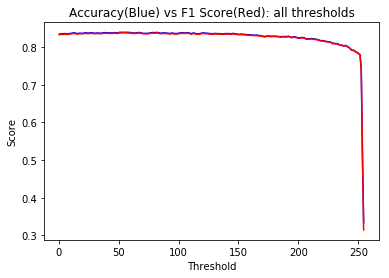

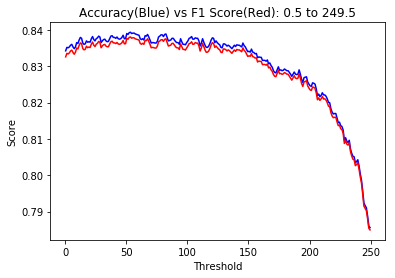

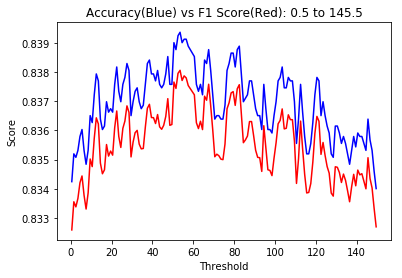

In [5]:
binaryNB_accuracy_history = [];
binaryNB_f1_history = [];
for i in range(0,255):
    binaryNB = BernoulliNB(binarize = i+0.5).fit(train_x,train_y.values.ravel());
    binaryNB_valid = binaryNB.predict(valid_x);
    binaryNB_accuracy_history.append(accuracy_score(binaryNB_valid, valid_y));
    binaryNB_f1_history.append(f1_score(binaryNB_valid, valid_y, average = 'macro'));
    
plt.plot(np.arange(0,255)+0.5,binaryNB_accuracy_history,'b');
plt.plot(np.arange(0,255)+0.5,binaryNB_f1_history,'r');
plt.title("Accuracy(Blue) vs F1 Score(Red): all thresholds");
plt.xlabel("Threshold");
plt.ylabel("Score");
plt.show();

plt.plot(np.arange(0,250)+0.5,binaryNB_accuracy_history[:-5],'b');
plt.plot(np.arange(0,250)+0.5,binaryNB_f1_history[:-5],'r');
plt.title("Accuracy(Blue) vs F1 Score(Red): 0.5 to 249.5");
plt.xlabel("Threshold");
plt.ylabel("Score");
plt.show();

plt.plot(np.arange(0,150)+0.5,binaryNB_accuracy_history[:-105],'b');
plt.plot(np.arange(0,150)+0.5,binaryNB_f1_history[:-105],'r');
plt.title("Accuracy(Blue) vs F1 Score(Red): 0.5 to 145.5");
plt.xlabel("Threshold");
plt.ylabel("Score");
plt.show();

In [6]:
max_accuracy = binaryNB_accuracy_history.index(max(binaryNB_accuracy_history))+0.5;
max_f1 = binaryNB_f1_history.index(max(binaryNB_f1_history))+0.5;
"Accuracy on the validation set is maximized with a threshold of " + str(max_accuracy)
"F1 score on the validation set is maximized with a threshold of " + str(max_f1)

'Accuracy on the validation set is maximized with a threshold of 53.5'

'F1 score on the validation set is maximized with a threshold of 53.5'

In [7]:
binaryNB = BernoulliNB(binarize = 53.5).fit(train_x,train_y.values.ravel())
binaryNB_valid = binaryNB.predict(valid_x)
"Bernoulli Naive Bayes has an accuracy score of " + "{0:.6f}".format(accuracy_score(binaryNB_valid, valid_y))
"Bernoulli Naive Bayes has an F1 score of " + "{0:.6f}".format(f1_score(binaryNB_valid, valid_y, average = 'macro'))
# confusion_matrix(valid_y, binaryNB_valid)

gaussNB = GaussianNB().fit(train_x,train_y.values.ravel())
gaussNB_valid = gaussNB.predict(valid_x)
"Gaussian Naive Bayes has an accuracy score of " + "{0:.6f}".format(accuracy_score(gaussNB_valid, valid_y))
"Gaussian Naive Bayes has an F1 score of " + "{0:.6f}".format(f1_score(gaussNB_valid, valid_y, average = 'macro'))
# confusion_matrix(valid_y, gaussNB_valid)

'Bernoulli Naive Bayes has an accuracy score of 0.839362'

'Bernoulli Naive Bayes has an F1 score of 0.838059'

'Gaussian Naive Bayes has an accuracy score of 0.551166'

'Gaussian Naive Bayes has an F1 score of 0.497364'

In [8]:
ridge = RidgeClassifier(max_iter=1000).fit(train_x,train_y.values.ravel())
ridge_valid = ridge.predict(valid_x)
"Ridge Regression has an accuracy score of " + "{0:.6f}".format(accuracy_score(ridge_valid, valid_y))
"Ridge Regression has an F1 score of " + "{0:.6f}".format(f1_score(ridge_valid, valid_y, average = 'macro'))

'Ridge Regression has an accuracy score of 0.849952'

'Ridge Regression has an F1 score of 0.846943'

In [9]:
knn = KNeighborsClassifier(n_neighbors=4,weights='distance').fit(train_x,train_y.values.ravel())
knn_valid = knn.predict(valid_x)
"K-Nearest Neighbors has an accuracy score of " + "{0:.6f}".format(accuracy_score(knn_valid, valid_y))
"K-Nearest Neighbors has an F1 score of " + "{0:.6f}".format(f1_score(knn_valid, valid_y, average = 'macro'))

'K-Nearest Neighbors has an accuracy score of 0.971204'

'K-Nearest Neighbors has an F1 score of 0.971019'

In [10]:
rf = RandomForestClassifier(n_estimators=100,
                            min_samples_leaf=10,
                            random_state=42).fit(train_x,train_y.values.ravel())
rf_valid = rf.predict(valid_x)
"The Random Forest has an accuracy score of " + "{0:.6f}".format(accuracy_score(rf_valid, valid_y))
"The Random Forest has an F1 score of " + "{0:.6f}".format(f1_score(rf_valid, valid_y, average = 'macro'))

'The Random Forest has an accuracy score of 0.951690'

'The Random Forest has an F1 score of 0.951331'

In [11]:
boost = GradientBoostingClassifier(n_estimators=100,
                                   max_depth=5,
                                   min_samples_split=15,
                                   random_state=42).fit(train_x,train_y.values.ravel())
boost_valid = boost.predict(valid_x)
"The Gradient Boosted Forest has an accuracy score of " + "{0:.6f}".format(accuracy_score(boost_valid, valid_y))
"The Gradient Boosted Forest has an F1 score of " + "{0:.6f}".format(f1_score(boost_valid, valid_y, average = 'macro'))

'The Gradient Boosted Forest has an accuracy score of 0.962399'

'The Gradient Boosted Forest has an F1 score of 0.962083'

In [15]:
base_tree = DecisionTreeClassifier(max_depth=25, min_samples_split = 15)
ada = AdaBoostClassifier(base_estimator=base_tree,n_estimators=100,random_state=42).fit(train_x,train_y.values.ravel())
ada_valid = ada.predict(valid_x)
"The AdaBoosted Forest has an accuracy score of " + "{0:.6f}".format(accuracy_score(ada_valid, valid_y))
"The AdaBoosted Forest has an F1 score of " + "{0:.6f}".format(f1_score(ada_valid, valid_y, average = 'macro'))

'The AdaBoosted Forest has an accuracy score of 0.965731'

'The AdaBoosted Forest has an F1 score of 0.965450'

In [13]:
linsvm = LinearSVC().fit(train_x,train_y.values.ravel())
linsvm_valid = linsvm.predict(valid_x)
"The Linear Support Vector Machine has an accuracy score of " + "{0:.6f}".format(accuracy_score(linsvm_valid, valid_y))
"The Linear Support Vector Machine has an F1 score of " + "{0:.6f}".format(f1_score(linsvm_valid, valid_y, average = 'macro'))

'The Linear Support Vector Machine has an accuracy score of 0.845431'

'The Linear Support Vector Machine has an F1 score of 0.842538'

In [14]:
# np.random.seed(945)
# random_rows = np.random.choice(train_x.shape[0], 15000, replace=False)
# kernsvm = SVC(C=5, gamma = 0.0000005).fit(train_x.iloc[random_rows,:],train_y.iloc[random_rows,:].values.ravel())
kernsvm = SVC(C=5, gamma = 0.0000005).fit(train_x,train_y.values.ravel())
kernsvm_valid = kernsvm.predict(valid_x)
"The Kernel Support Vector Machine has an accuracy score of " + "{0:.6f}".format(accuracy_score(kernsvm_valid, valid_y))
"The Kernel Support Vector Machine has an F1 score of " + "{0:.6f}".format(f1_score(kernsvm_valid, valid_y, average = 'macro'))

'The Kernel Support Vector Machine has an accuracy score of 0.982627'

'The Kernel Support Vector Machine has an F1 score of 0.982491'